##### Author  : SIVA VIKNESH & YOUNES TATARI
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com , younes.tatari@utah.edu/ younes.tatari@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA

In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]
import vtk
from vtk.util import numpy_support as VN
from itertools import combinations

ABC Flow

Paper:

The flow differential equations are:

U component of the velocity
$$
\dot{x} = Asin(w1z) +Ccos(w2y)
$$
V component of the velocity
$$
\dot{y} = Bsin(w3x) + Acos(w4z)
$$
W component of the velocity
$$
\dot{z} = Csin(w5y) + Bcos(w6x)
$$

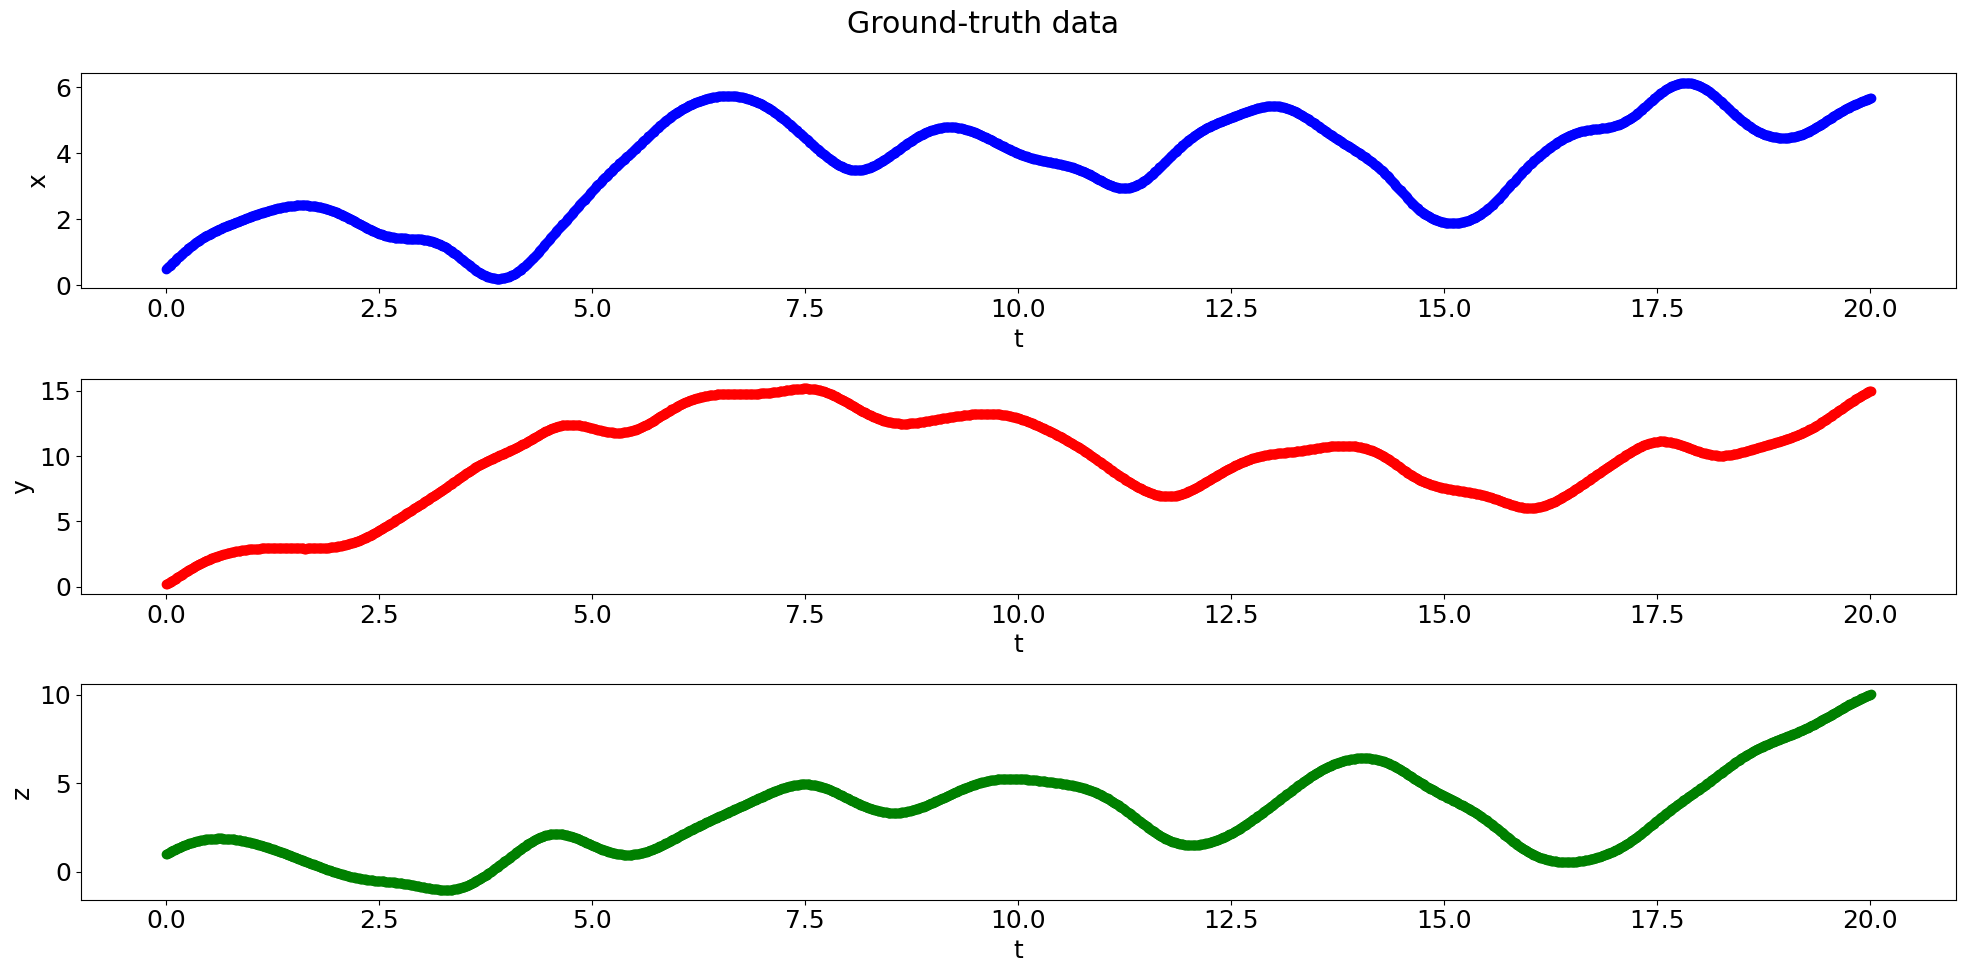

In [2]:
dt = 0.01
T = 20.0
t = np.arange(0,T+dt,dt)
A = 2.0
B = 3.0
C = 1.0

w1 =  np.pi/4.0
w2 =  np.pi/3.0
w3 =  np.pi/2.0
w4 =  np.pi/5.0
w5 =  np.pi/4.5
w6 =  np.pi/2.8


def ABC_deriv(x_y_z, t0, A = A, B = B, C = C,w1=w1, w2=w2, w3=w3, w4=w4, w5=w5, w6=w6 ):
    x, y, z = x_y_z
    dxdt = A*np.sin(w1*z) + C*np.cos(w2*y)
    dydt = B*np.sin(w3*x) + A*np.cos(w4*z)
    dzdt = C*np.sin(w5*y) + B*np.cos(w6*x)
    return [dxdt, dydt, dzdt]

np.random.seed(123)
x0 = (0.5, 0.2, 1.0)
x_t = integrate.odeint(ABC_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y, z = x_t.T

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o',color='blue')
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o',color='red')
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

ax[2].plot(t, z, '-o',color='green')
#ax[1].set_title('$y$')
ax[2].set(xlabel="t",ylabel="z")

fig.tight_layout()
plt.show()

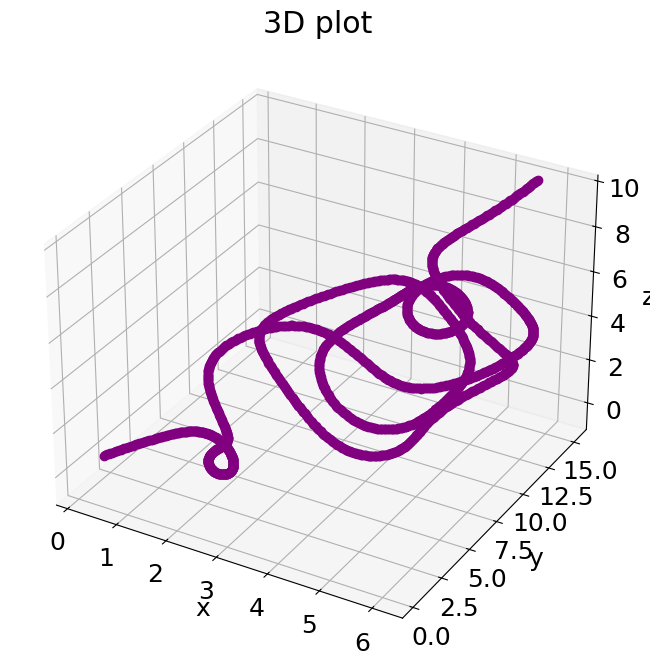

In [3]:
# Plotting the 3D figure
fig_3d = plt.figure(figsize=(10, 8))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.plot(x, y, z, '-o', color='purple')
ax_3d.set(xlabel="x", ylabel="y", zlabel="z")
ax_3d.set_title('3D plot')

plt.show()

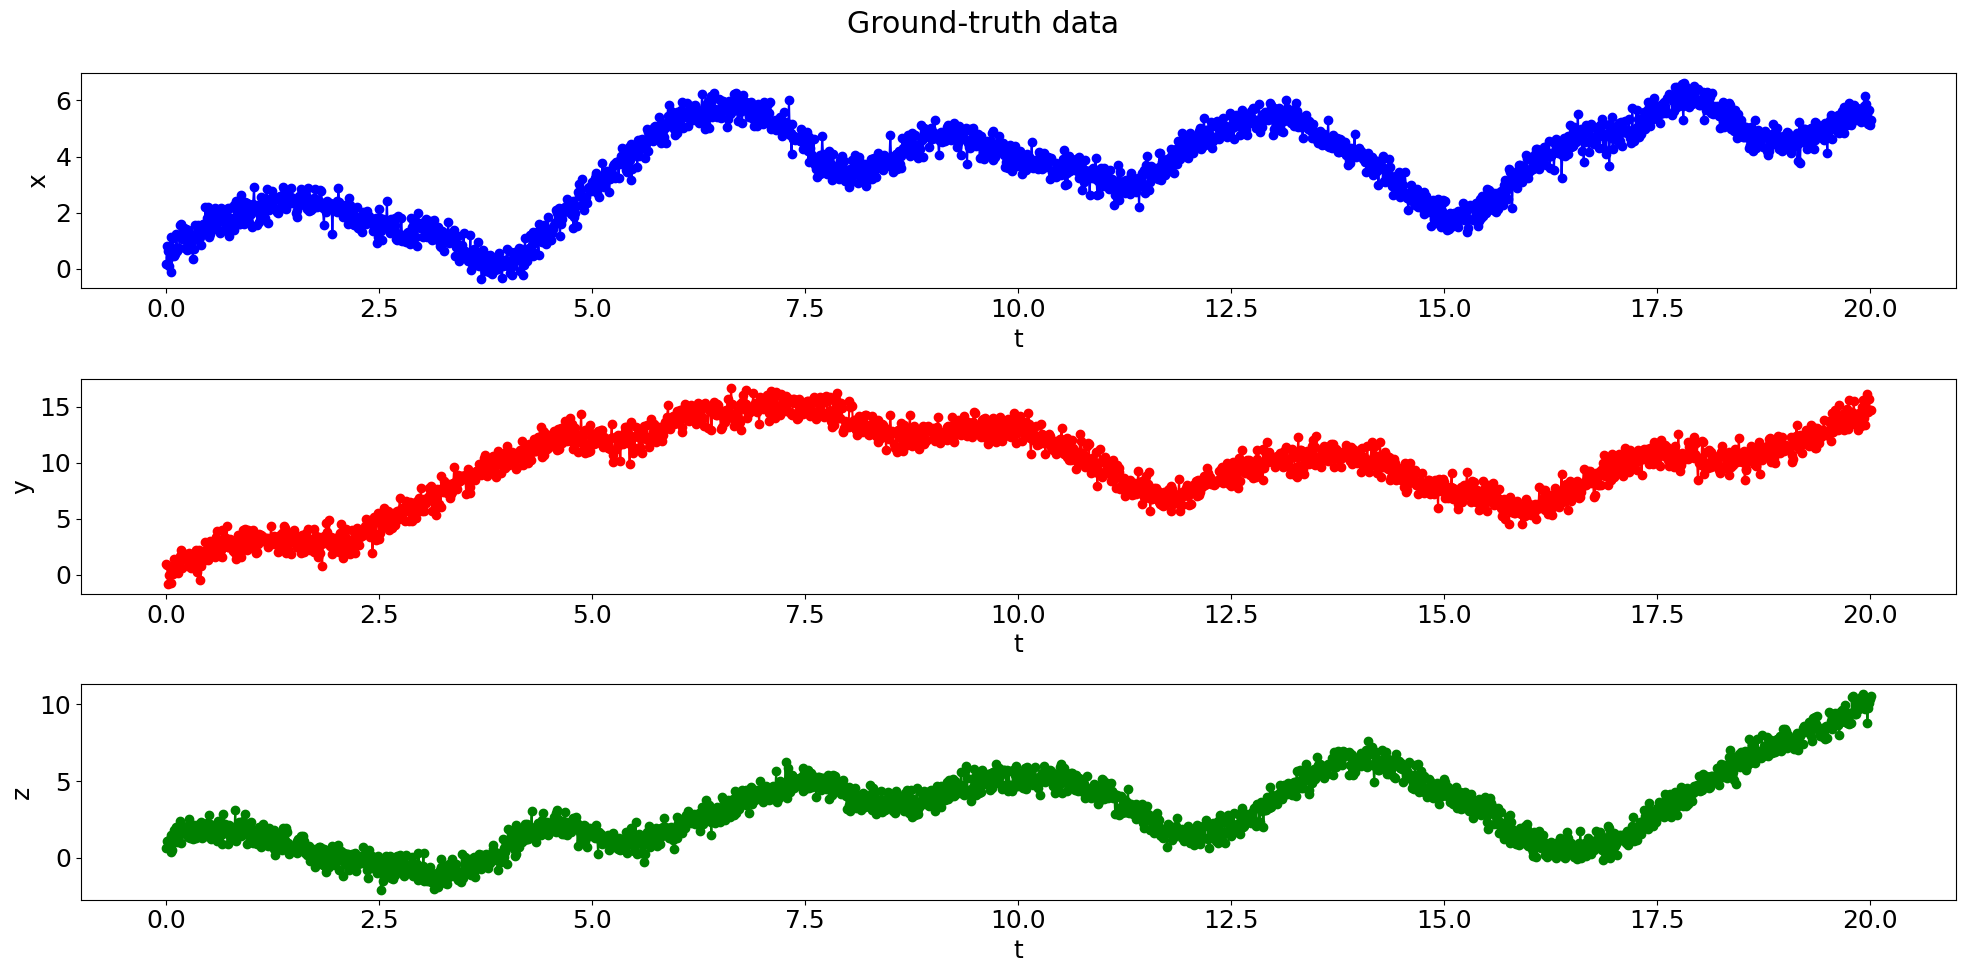

In [4]:
# ADDING ARTIFICAL NOISE TO THE DATA
std_percent = 0.20                                  # STANDARD DEVIATION (INTENSITY OF NOISE)

x_noise = np.random.normal(0, np.std(x), x.shape)*std_percent
y_noise = np.random.normal(0, np.std(y), y.shape)*std_percent
z_noise = np.random.normal(0, np.std(z), z.shape)*std_percent

x += x_noise
y += y_noise
z += z_noise

fig, ax = plt.subplots(nrows = 3,ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o',color='blue')
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o',color='red')
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

ax[2].plot(t, z, '-o',color='green')
#ax[1].set_title('$y$')
ax[2].set(xlabel="t",ylabel="z")

fig.tight_layout()
plt.show()

In [5]:
# COMPUTING THE COMBINATIONS AMONG THE THREE CHOSEN TEMPORAL MODES

def POOL_DATA(yin, nVars, polyorder):
    n = yin.shape[0]
    yout = torch.zeros((n, 1)).to(processor)

    # poly order 0
    yout[:, 0] = torch.zeros(n)

    # poly order 1
    for i in range(nVars):
        yout = torch.cat((yout, yin[:, i].reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout = torch.cat((yout, (yin[:, i] * yin[:, j]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    yout = torch.cat((yout, (yin[:, i] * yin[:, j] * yin[:, k]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    return yout

def DERIVATIVE(x, y, z, A, B, C, w1, w2, w3, w4, w5, w6 ):
    dxdt = A*torch.sin(w1*z) + C*torch.cos(w2*y)
    dydt = B*torch.sin(w3*x) + A*torch.cos(w4*z)
    dzdt = C*torch.sin(w5*y) + B*torch.cos(w6*x)
    return torch.vstack((dxdt, dydt, dzdt)).T


AVAILABLE PROCESSOR: cuda 



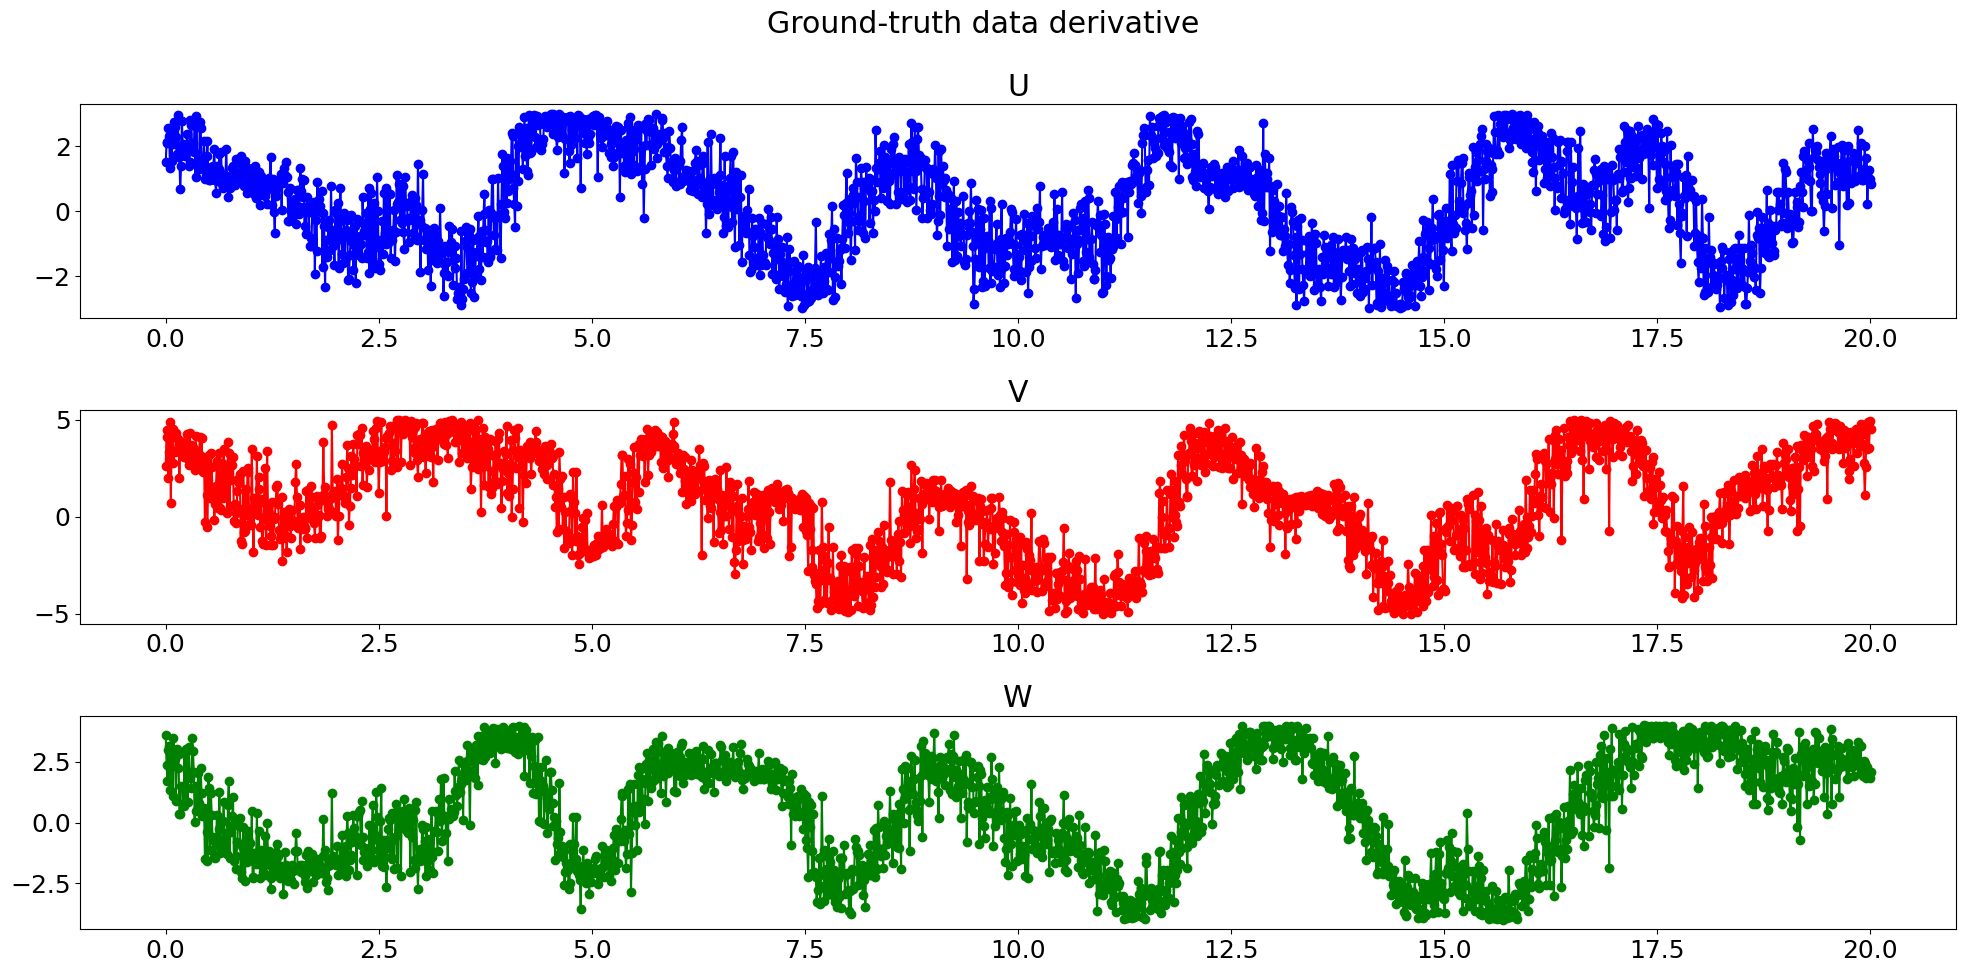

In [6]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

N_modes  = 3
x_t      = torch.Tensor(x_t).to(processor)
x        = torch.Tensor(x).to(processor)
y        = torch.Tensor(y).to(processor)
z        = torch.Tensor(z).to(processor)
t        = torch.Tensor(t).to(processor)

A_candidates  = POOL_DATA (x_t, N_modes, 1).to(processor)
A_candidates  = A_candidates[:, 1:]
A1A2A3_time_deriv = DERIVATIVE (x, y, z, A, B, C, w1, w2, w3, w4, w5, w6).to(processor)


# HYPERPARAMETERS FOR THE SINDy POD METHODOLOGY
Epochs        = 40000
learning_rate = 1e-2
step_epoch    = 3000
decay_rate    = 0.5


fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t.detach().cpu().numpy(), A1A2A3_time_deriv[:, 0].detach().cpu().numpy(), '-o',color='blue')
ax[0].set_title('U')

ax[1].plot(t.detach().cpu().numpy(), A1A2A3_time_deriv[:, 1].detach().cpu().numpy(), '-o',color='red')
ax[1].set_title('V')

ax[2].plot(t.detach().cpu().numpy(), A1A2A3_time_deriv[:, 2].detach().cpu().numpy(), '-o',color='green')
ax[2].set_title('W')

fig.tight_layout()
plt.show()

In [7]:
class SINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sin(self.b*x)
        return output

class COSINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.cos(self.b*x)
        return output

In [8]:
class ADAPTIVE_SINDy_MODEL(nn.Module):
    def __init__(self, a, asine, acosine):
        super().__init__()
        self.a        = a
        self.asine    = asine
        self.acosine  = acosine

        self.sine     = SINE_TERM   (self.asine)
        self.cosine   = COSINE_TERM (self.acosine)

    def forward(self, x):
        output_sine    = self.sine   (x)
        output_cosine  = self.cosine (x)

        output = torch.hstack((output_sine, output_cosine )) @ self.a
        return output


In [9]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(6, N_modes, requires_grad= True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)
XSINE_ADT   = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1], N_modes, requires_grad= True, device= processor)

In [10]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, SINE_ADT, COSINE_ADT ], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
Lambda   = Parameter(torch.tensor(1.0), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda],  lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)


In [ ]:
# TEMPORAL MODE 1
A1_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0] ).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1] ).to(processor)

# TEMPORAL MODE 3
A3_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 2], SINE_ADT [:, 2], COSINE_ADT[:, 2] ).to(processor)

Loss_data     = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    A1_out, A2_out, A3_out  = A1_DT (A_candidates), A2_DT (A_candidates), A3_DT (A_candidates)
    output_data  = torch.stack((A1_out , A2_out, A3_out), dim = 1)
    loss_epoch   = loss_function (A1A2A3_time_deriv, output_data) + torch.linalg.matrix_norm(torch.abs(WEIGHTS)*COEFF_ADT, ord =1)

    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    optim_weights.zero_grad()
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()
        optim_weights.step()
        Loss_data [epoch] = loss_epoch.detach()
        COEFF_ADT [torch.abs(COEFF_ADT) <= 1e-3] = 0.0

    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)

    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

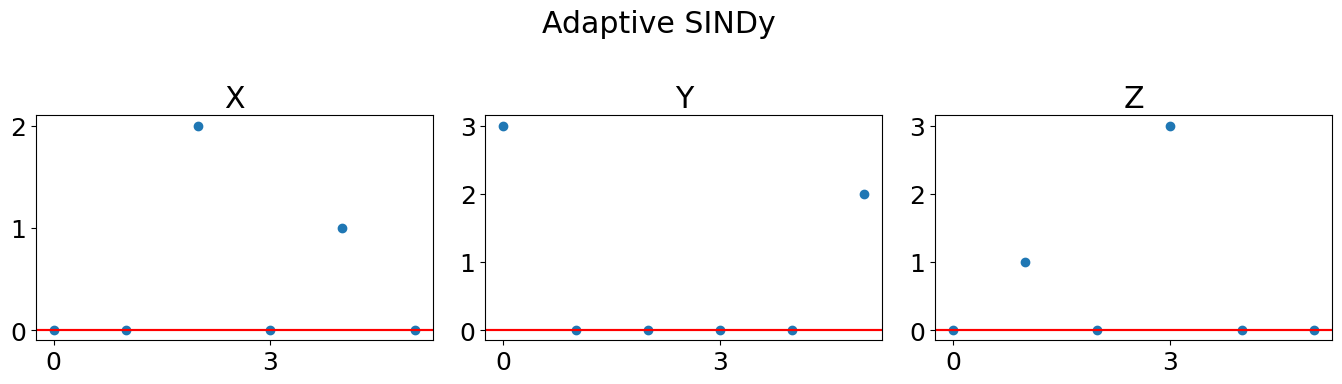

In [12]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o')
ax[1].set_title('Y')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

ax[2].plot(COEFF_ADT [:, 2].detach().cpu().numpy(), 'o')
ax[2].set_title('Z')
ax[2].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[2].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[2].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()


In [13]:
print(COEFF_ADT[:, 0])
print(COEFF_ADT[:, 1])
print(COEFF_ADT[:, 2])
print(SINE_ADT [:, 0], COSINE_ADT[:, 0])
print(SINE_ADT [:, 1], COSINE_ADT[:, 1])
print(SINE_ADT [:, 2], COSINE_ADT[:, 2])

tensor([0.0000, 0.0000, 2.0000, 0.0000, 1.0000, 0.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([3., 0., 0., 0., 0., 2.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0000, 1.0000, 0.0000, 3.0000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([1.2499, 1.0608, 0.7854], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3577, 1.0472, 0.8078], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1.5708, 0.8913, 0.5501], device='cuda:0', grad_fn=<SelectBackward0>) tensor([1.0265, 1.0357, 0.6283], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1.1308, 0.6981, 0.7027], device='cuda:0', grad_fn=<SelectBackward0>) tensor([1.1220, 1.7332, 1.0083], device='cuda:0', grad_fn=<SelectBackward0>)


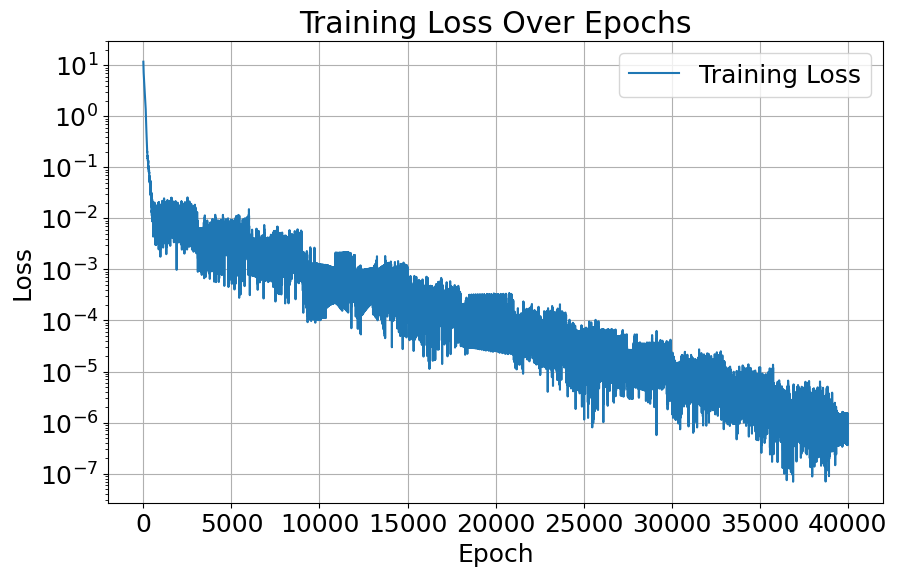

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy(), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()